# Context Mixing in Transformers

Hosein Mohebbi

---
### Measures of context-mixing:

- **Attention:** Raw self-attention weights averaged over all heads

- **Attention-Rollout:** Aggregated attention weights over previous layers using Rollout method (Abnar & Zuidema, ACL 2020)

- **Attention-Norm:** Norm of multiplication of attention weights and transformed value vectors (Kobayashi et al., EMNLP 2020)
  
- **Attention-Norm + RES1:** Incorporates the effect of the first residual stream into the Attention-Norm (Kobayashi et al., EMNLP 2021)

- **Attention-Norm + RES1 + LN1:** Incorporates the effect of the first residual stream and layer normalization into the Attention-Norm (Kobayashi et al., EMNLP 2021)

- **GlobEnc:** Rollout version of Attention-Norm + RES1 + LN1 where the effect of the second layer normalization is also taken into account (Modarressi et al., NAACL 2022)

- **Value Zeroing:** Considers all components inside Transformer by measuring how much token representations are affected when nullifying the value vector of each token (Mohebbi et al., EACL 2023)


In [ ]:
# @title Install Requirements
from IPython.display import clear_output
!git clone https://github.com/hmohebbi/context_mixing_toolkit.git
!pip install -r /content/context_mixing_toolkit/requirements.txt
clear_output()

In [ ]:
# @title Import Libraries
import pandas as pd
from plotnine import *
from IPython.display import display
import numpy as np
import torch
from huggingface_hub import notebook_login
from transformers import AutoTokenizer
from context_mixing_toolkit.src.modeling_bert import BertModel
from context_mixing_toolkit.src.modeling_roberta import RobertaModel
from context_mixing_toolkit.src.modeling_gemma import GemmaModel
from context_mixing_toolkit.src.utils import CMConfig, normalize, rollout

In [ ]:
# @title Login to HuggingFace Hub (needed only if you run Gemma model)
notebook_login()

In [ ]:
# @title Your Inputs
#@markdown Choose a pre-trained model
MODEL_PATH = "roberta-base" #@param ["roberta-base", "bert-base-uncased", "google/gemma-2b"]
#@markdown Choose your own input example! (For masking in encoder-only models, use \<mask> for RoBERTa and [MASK] for BERT)
# INPUT_EXAMPLE = "Either you win the game or you <mask> the game." #@param {type:"string"}
INPUT_EXAMPLE = "Either you win the game or you <mask> the game." #@param {type:"string"}
# Either you win the game or you
# Either you win the game or you <mask> the game.
# Either you win the game or you [MASK] the game.

#@markdown Choose measures of context-mixing: For Gemma model, only attention & Value Zeroing are available.
Attetnion = True #@param {type:"boolean"}
Attetnion_Rollout = True #@param {type:"boolean"}
AttentionNorm = True #@param {type:"boolean"}
AttentionNorm_RES1 = True #@param {type:"boolean"}
AttentionNorm_RES1_LN1 = True #@param {type:"boolean"}
GlobEnc = True #@param {type:"boolean"}
ValueZeroing = True #@param {type:"boolean"}



In [ ]:
# @title Compute scores
cm_config = CMConfig(output_attention=Attetnion, output_attention_norm=AttentionNorm, output_globenc=GlobEnc, output_value_zeroing=ValueZeroing)

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
if "roberta" in MODEL_PATH:
    model = RobertaModel.from_pretrained(MODEL_PATH)
elif "bert" in MODEL_PATH:
    model = BertModel.from_pretrained(MODEL_PATH)
elif "gemma" in MODEL_PATH:
    model = GemmaModel.from_pretrained(MODEL_PATH, attn_implementation='eager') #, torch_dtype=torch.bfloat16
else:
    raise ValueError("Context mixing methods have not been implemented for this model yet!")
model.eval()

inputs = tokenizer(INPUT_EXAMPLE, return_tensors="pt")
with torch.no_grad():
  outputs = model(**inputs, output_context_mixings=cm_config)

scores = {}
if Attetnion:
  scores['Attention'] = normalize(torch.stack(outputs['context_mixings']['attention']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if Attetnion_Rollout:
  scores['Attention-Rollout'] = rollout(scores['Attention'], res=True)
if AttentionNorm:
  scores['Attention-Norm'] = normalize(torch.stack(outputs['context_mixings']['attention_norm']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if AttentionNorm_RES1:
  scores['Attention-Norm + RES1'] = normalize(torch.stack(outputs['context_mixings']['attention_norm_res']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if AttentionNorm_RES1_LN1:
  scores['Attention-Norm + RES1 + LN1'] = normalize(torch.stack(outputs['context_mixings']['attention_norm_res_ln']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())
if GlobEnc:
  scores['GlobEnc'] = rollout(normalize(torch.stack(outputs['context_mixings']['globenc']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy()), res=False)
if ValueZeroing:
  scores['Value Zeroing'] = normalize(torch.stack(outputs['context_mixings']['value_zeroing']).permute(1, 0, 2, 3).squeeze(0).detach().cpu().numpy())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


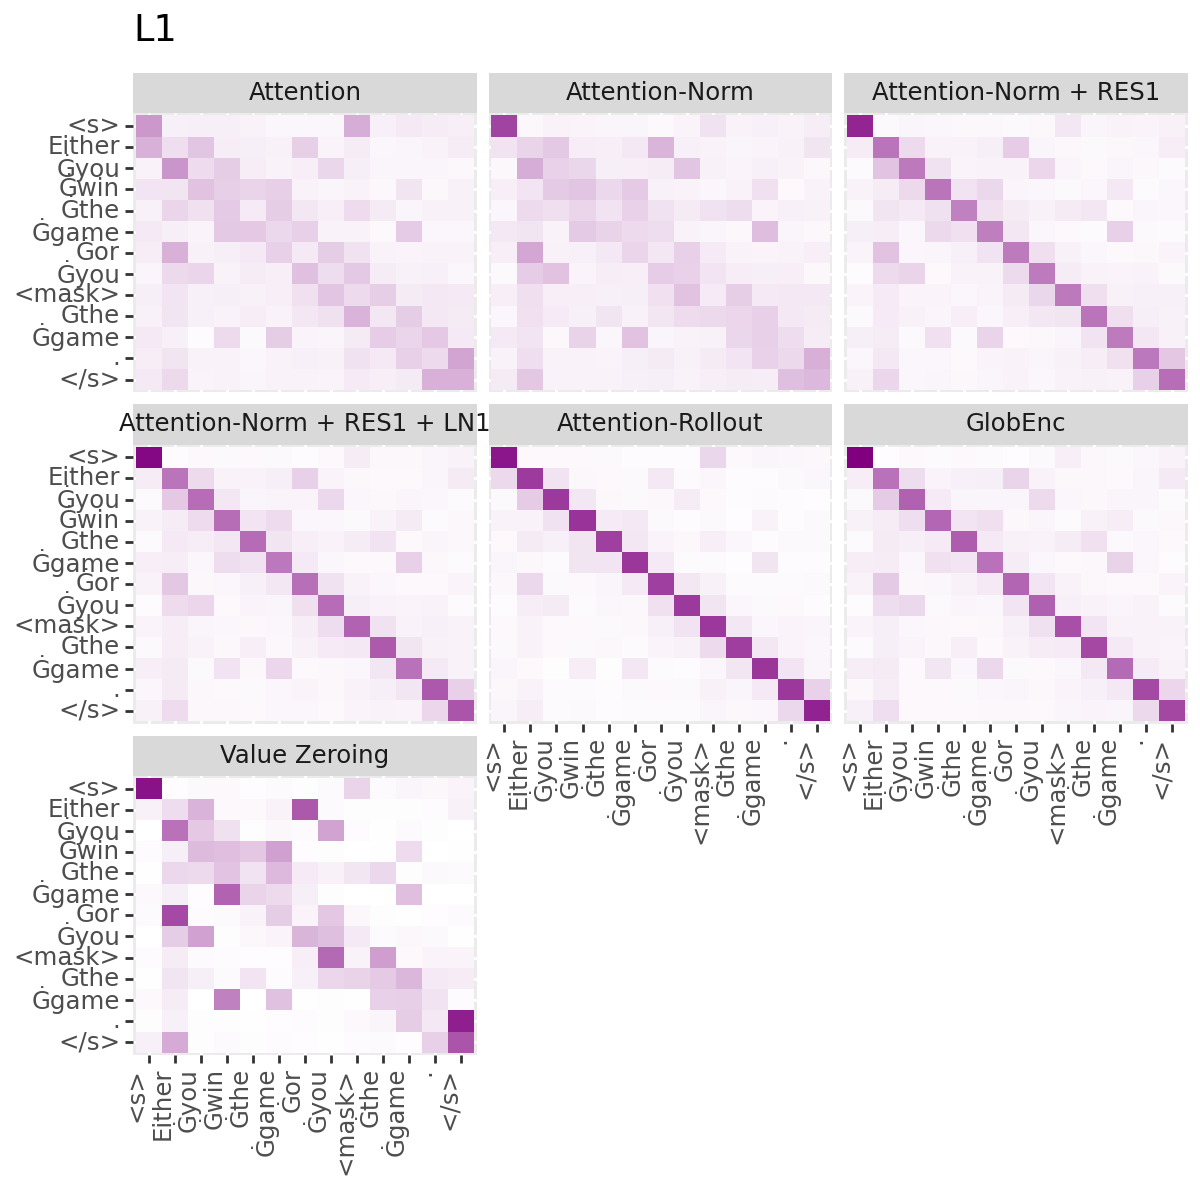

<Figure Size: (600 x 600)>

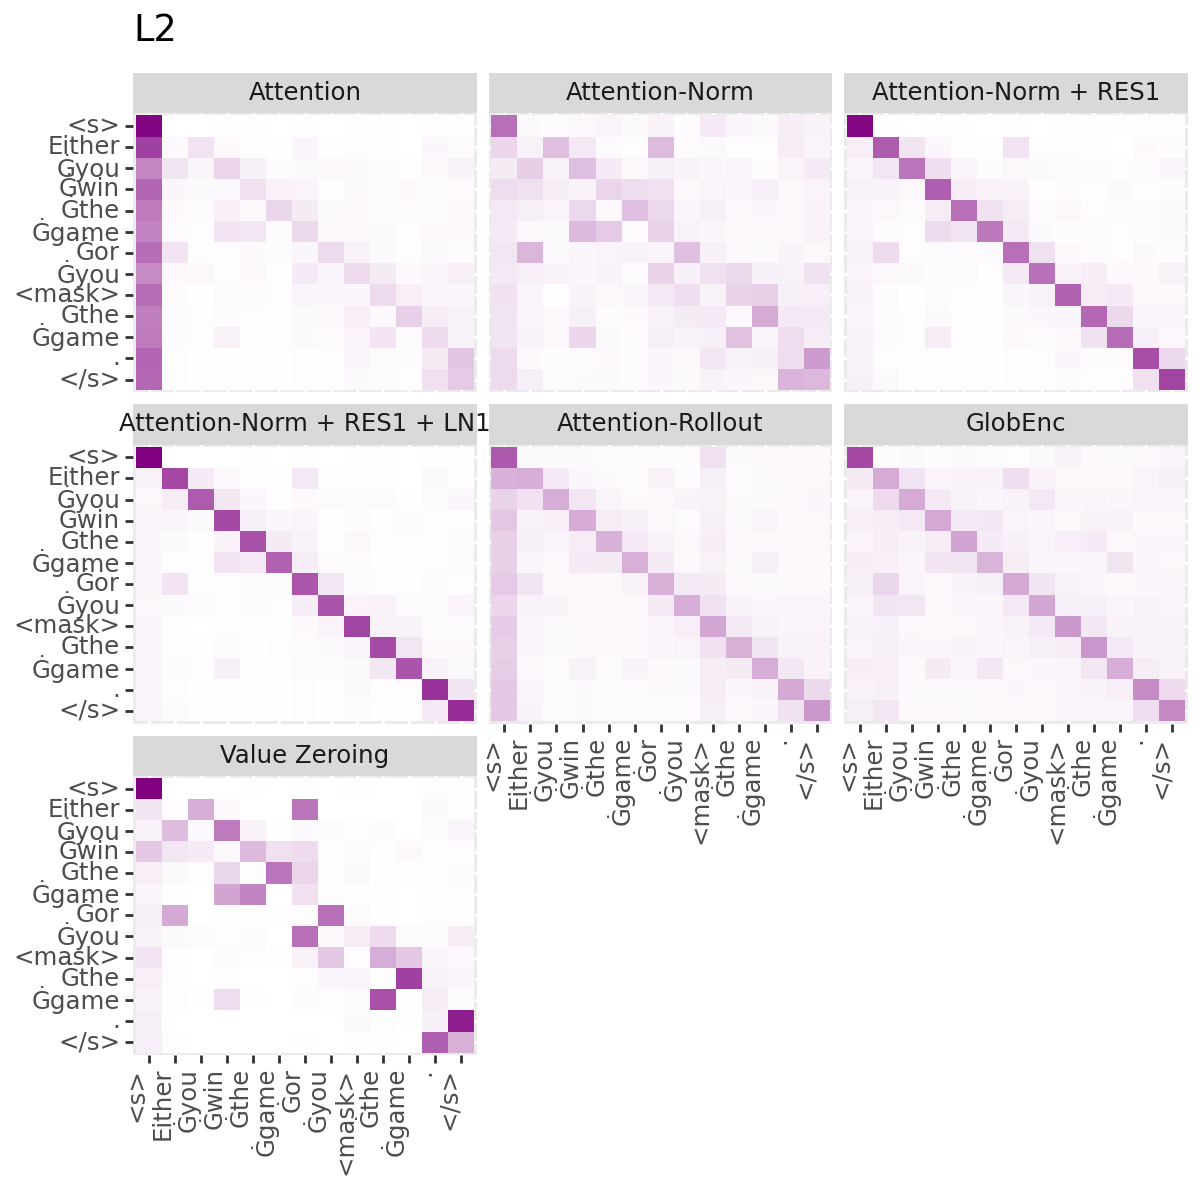

<Figure Size: (600 x 600)>

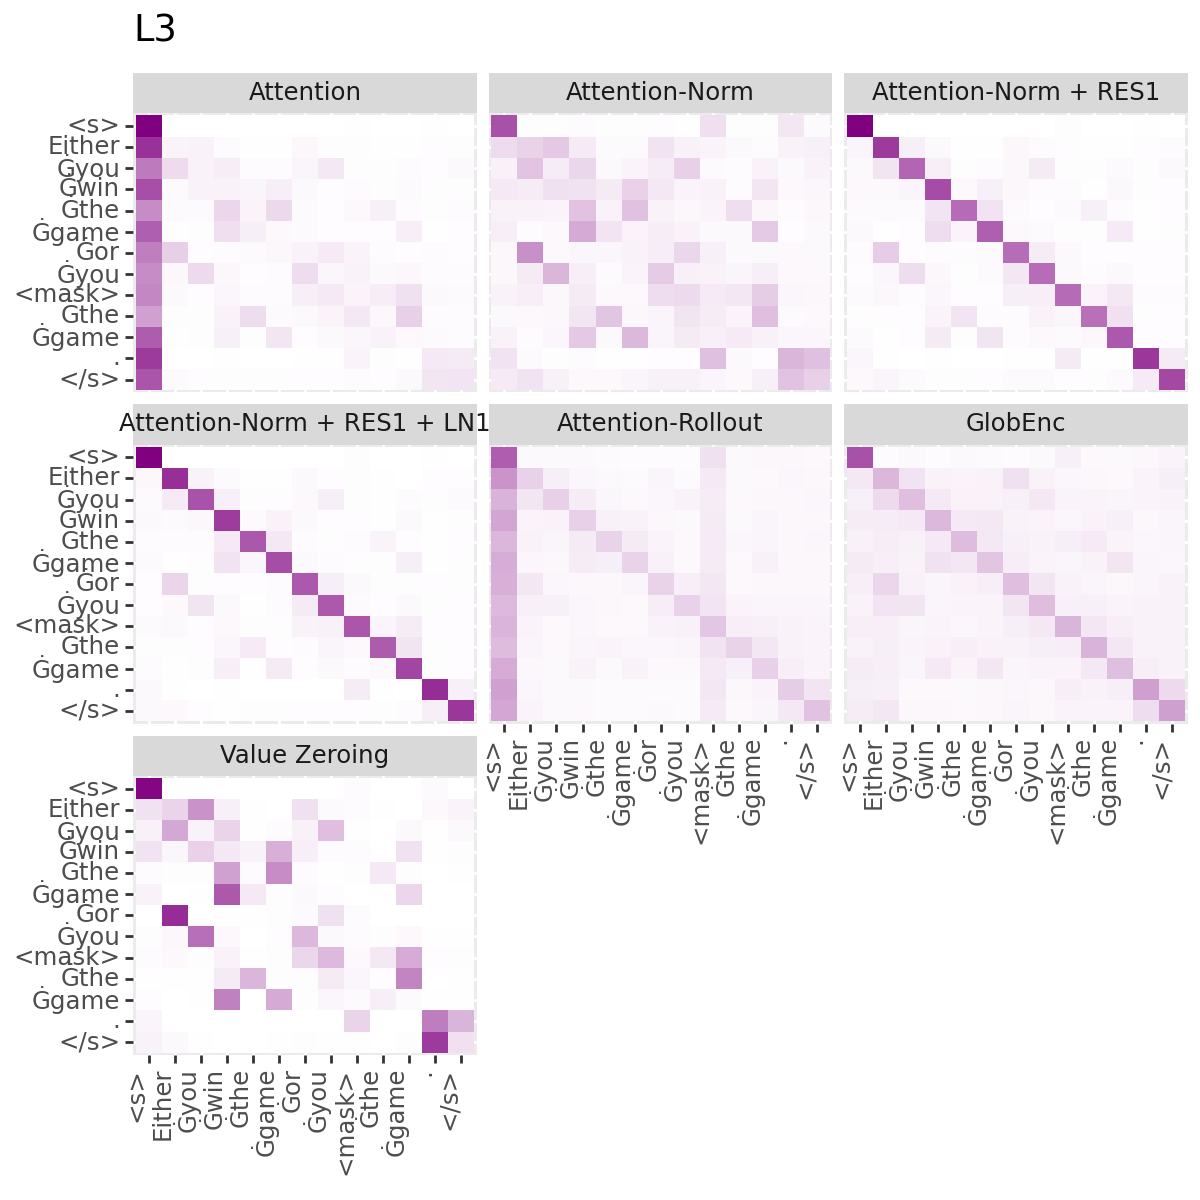

<Figure Size: (600 x 600)>

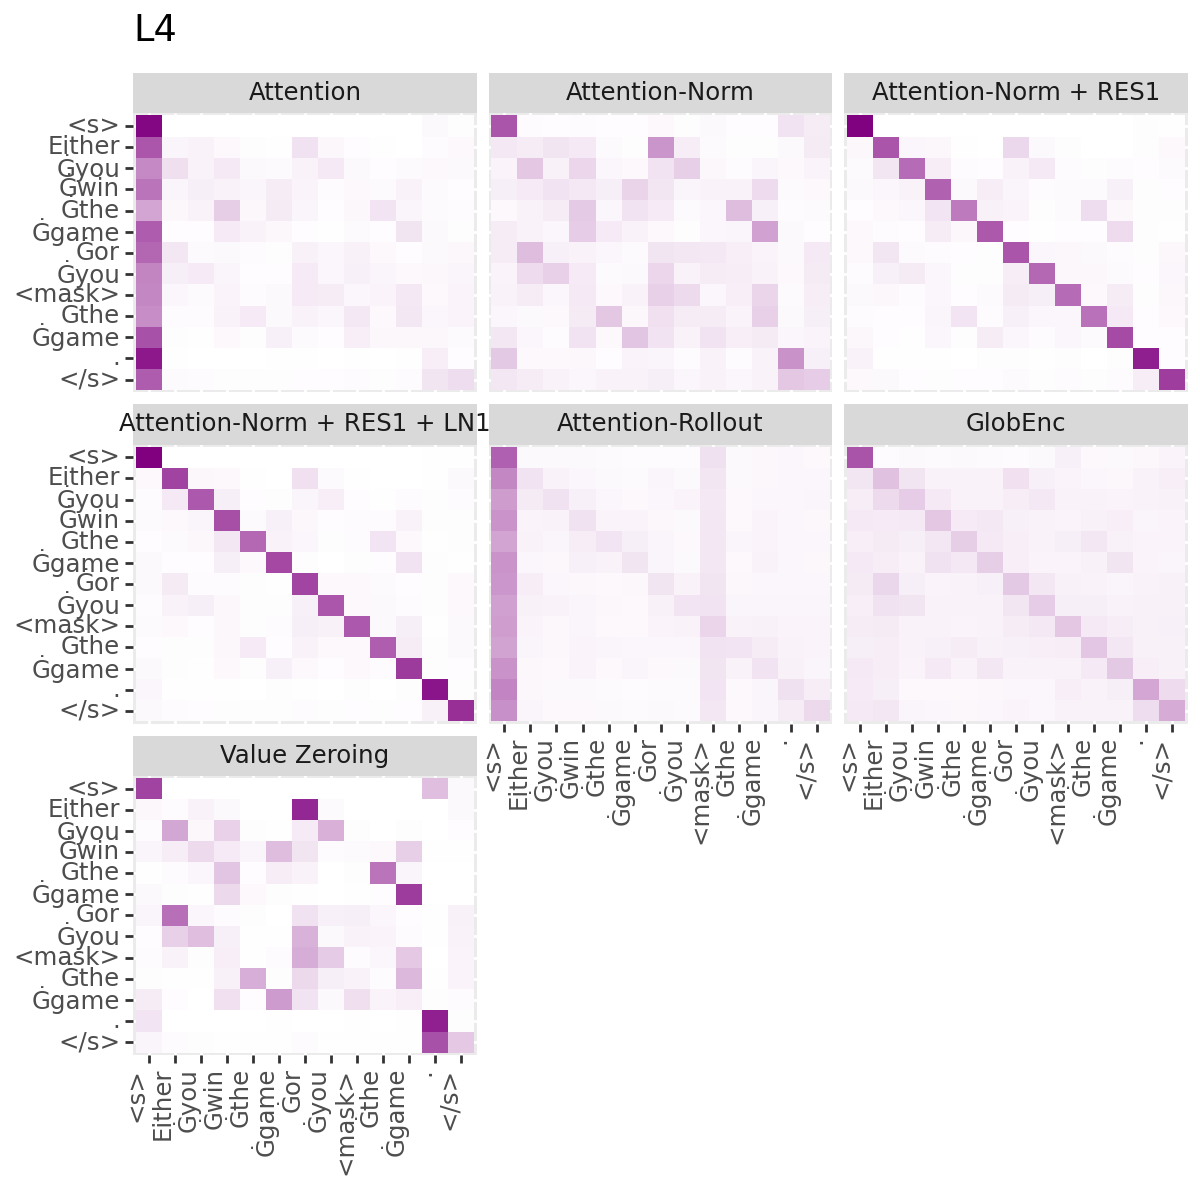

<Figure Size: (600 x 600)>

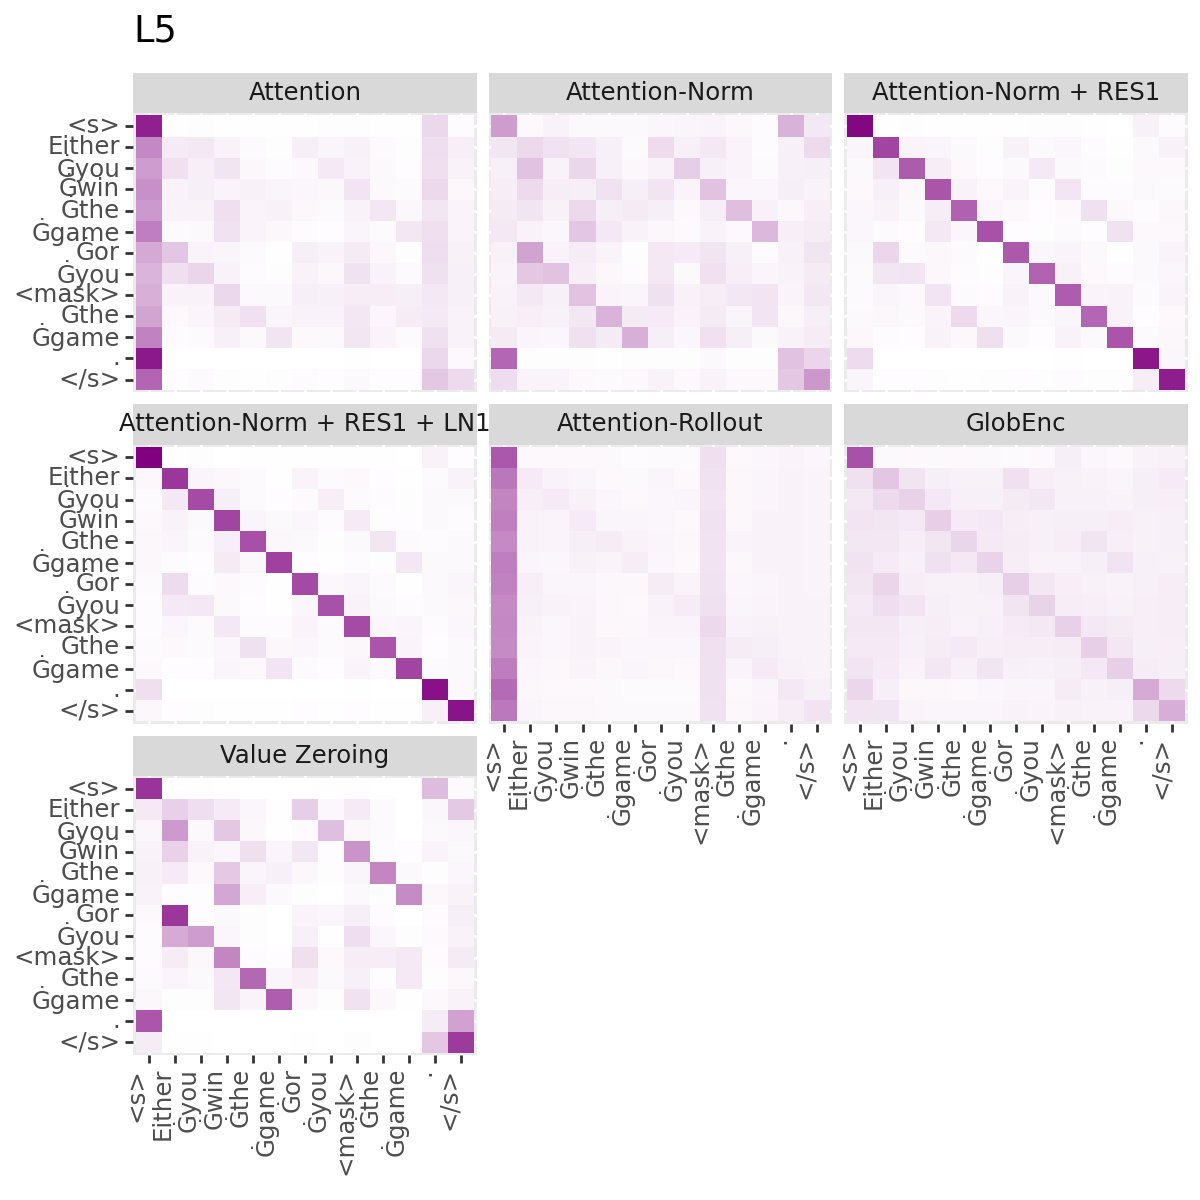

<Figure Size: (600 x 600)>

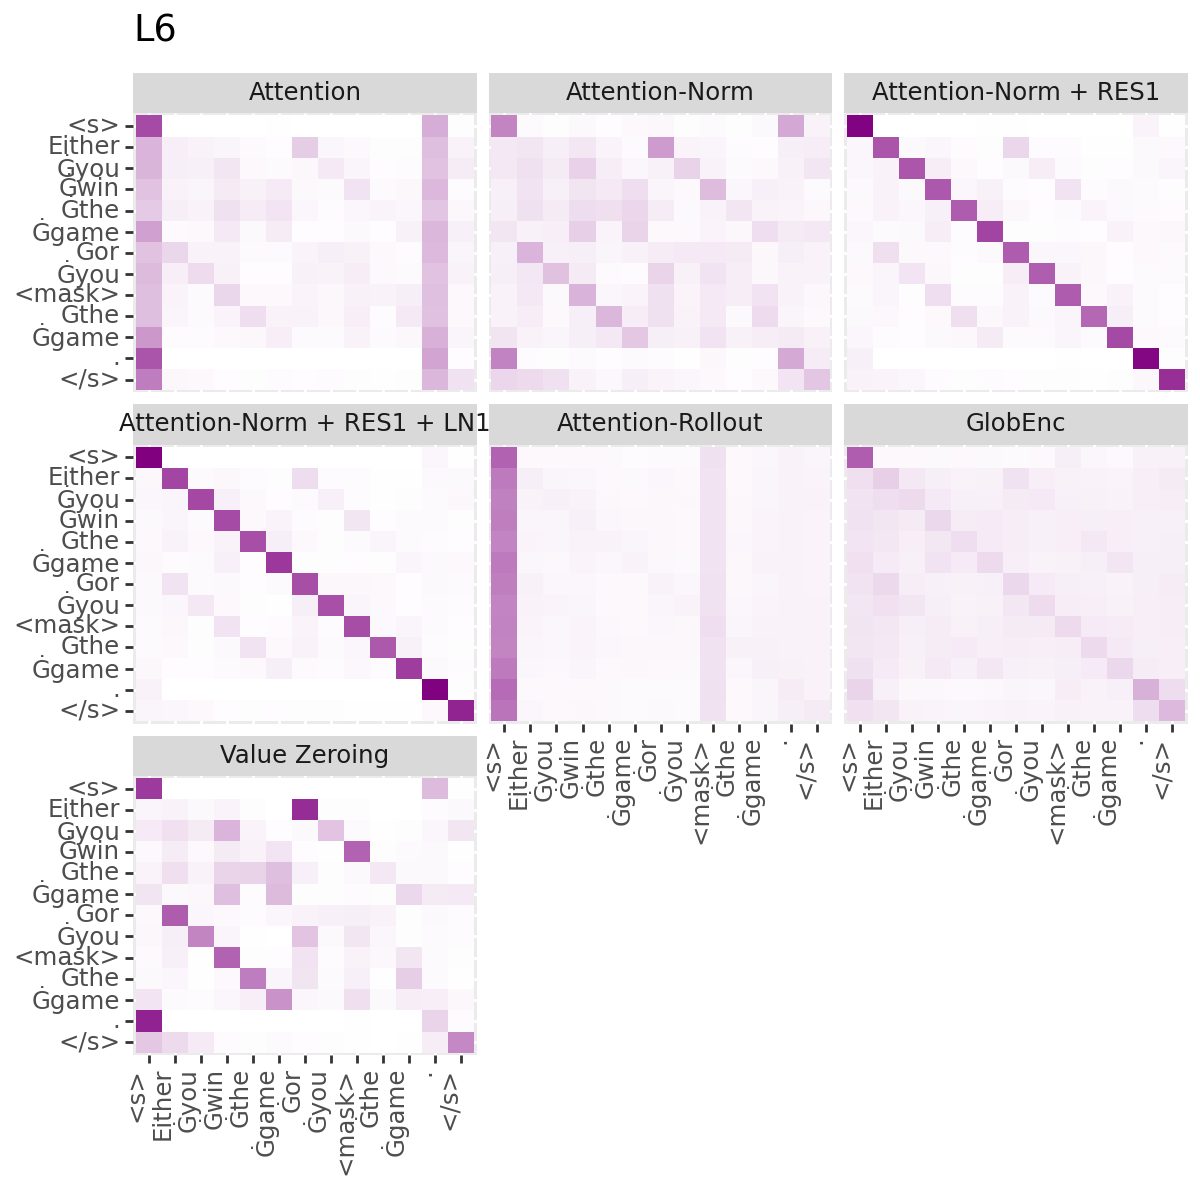

<Figure Size: (600 x 600)>

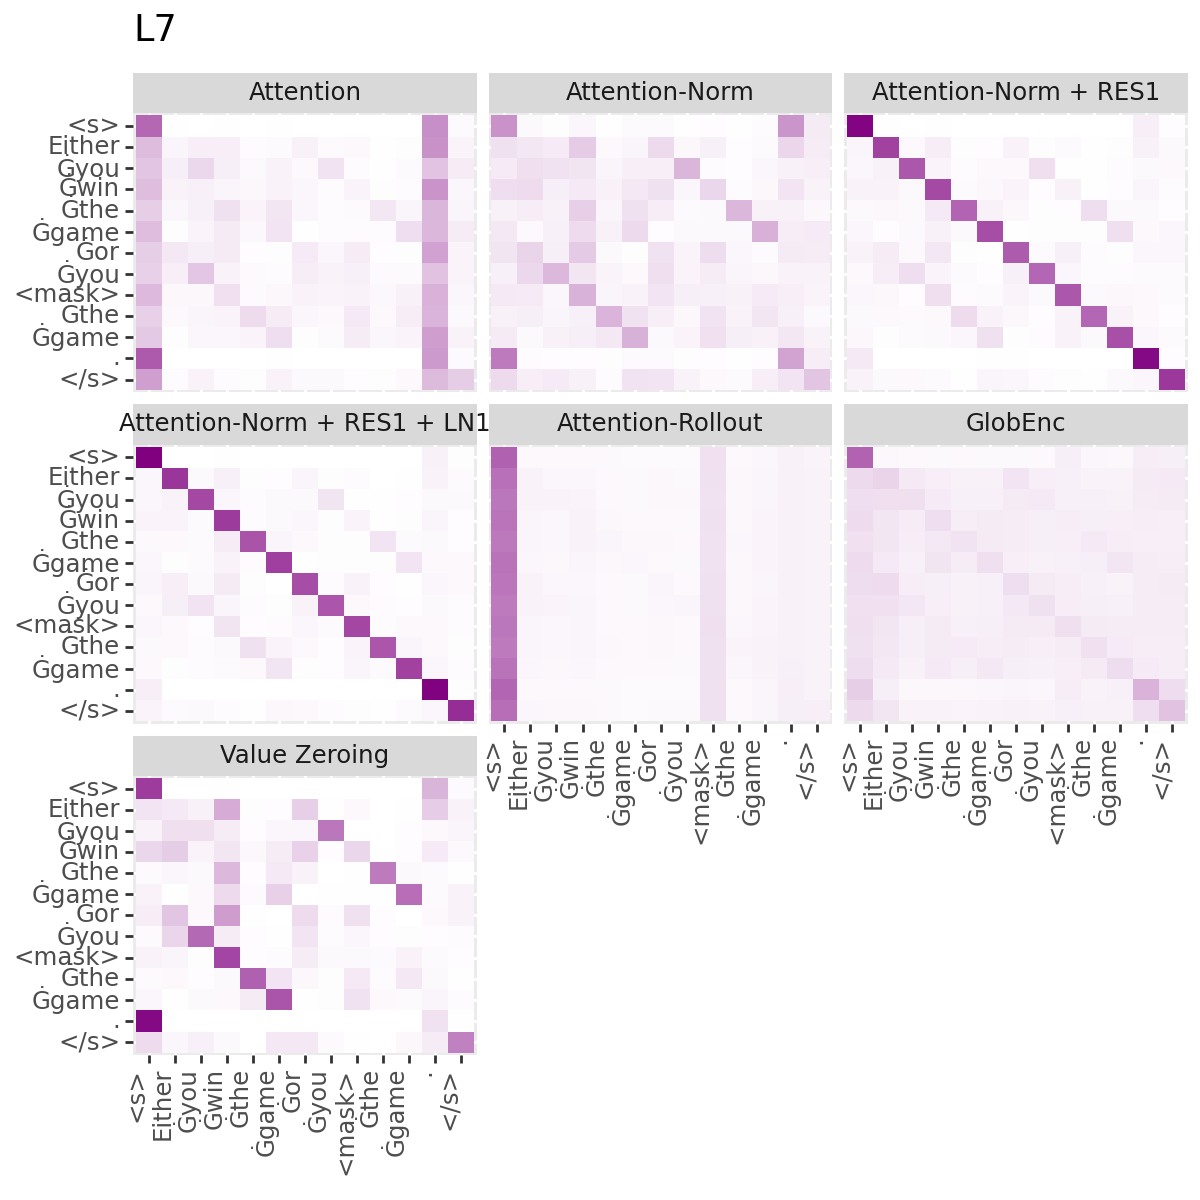

<Figure Size: (600 x 600)>

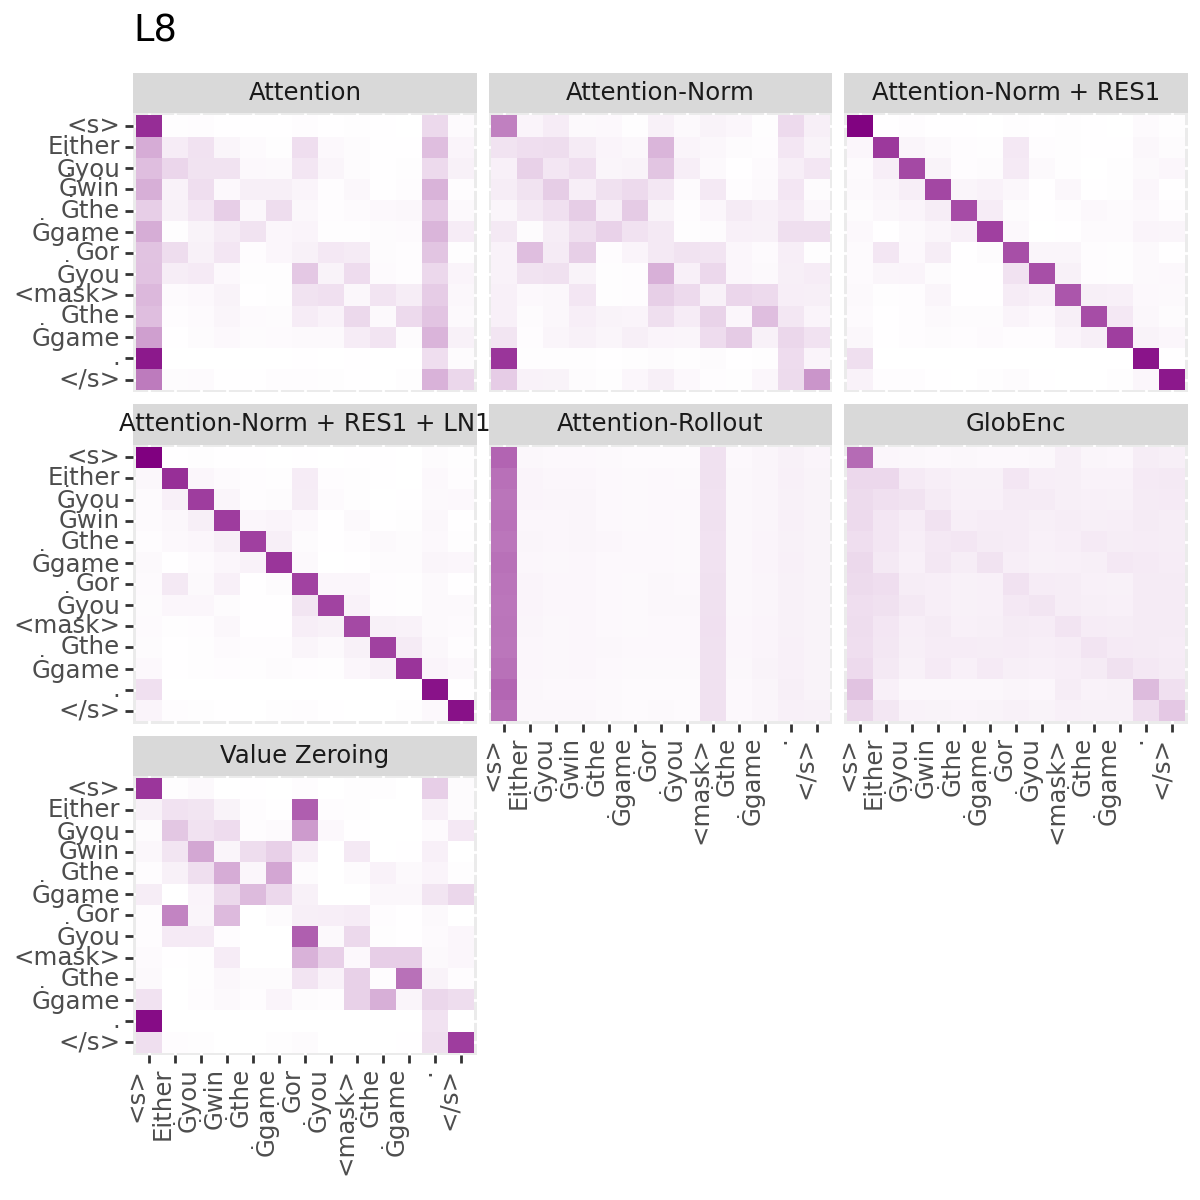

<Figure Size: (600 x 600)>

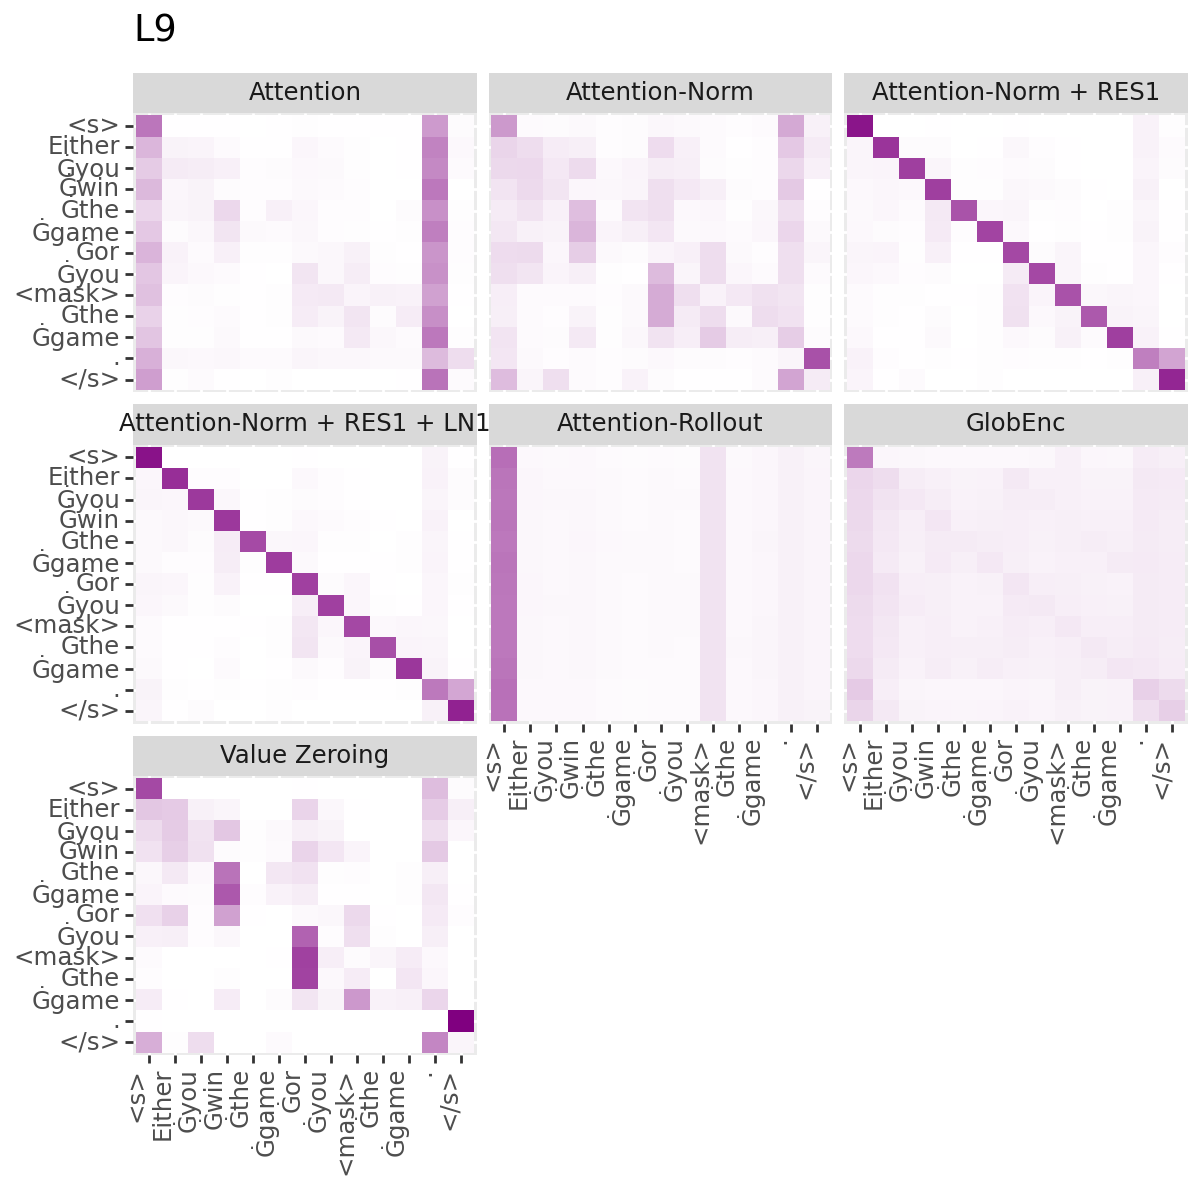

<Figure Size: (600 x 600)>

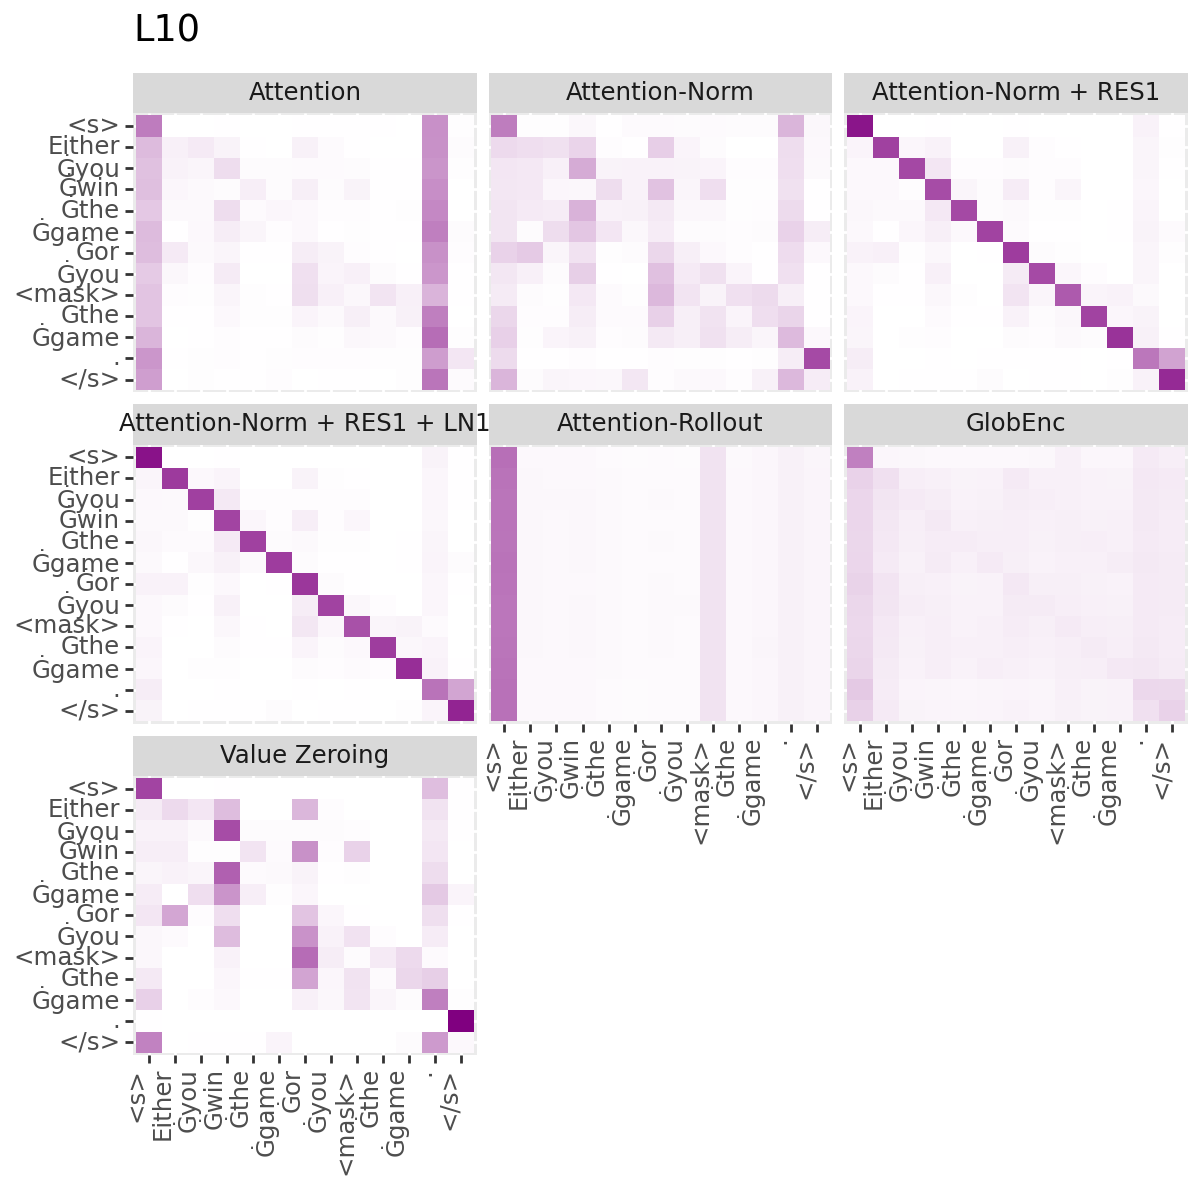

<Figure Size: (600 x 600)>

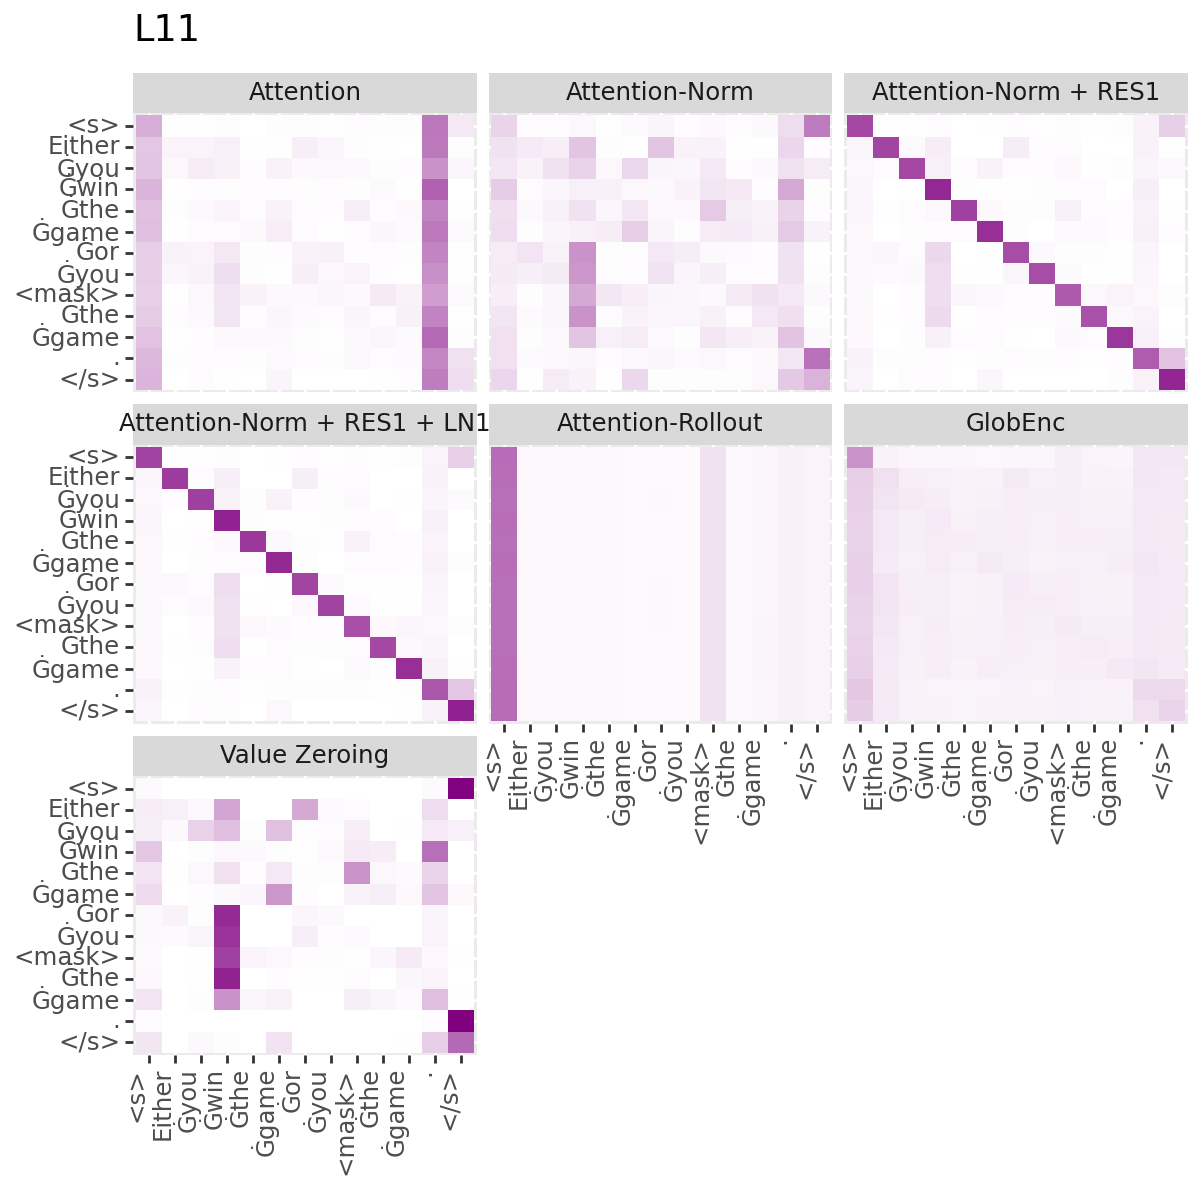

<Figure Size: (600 x 600)>

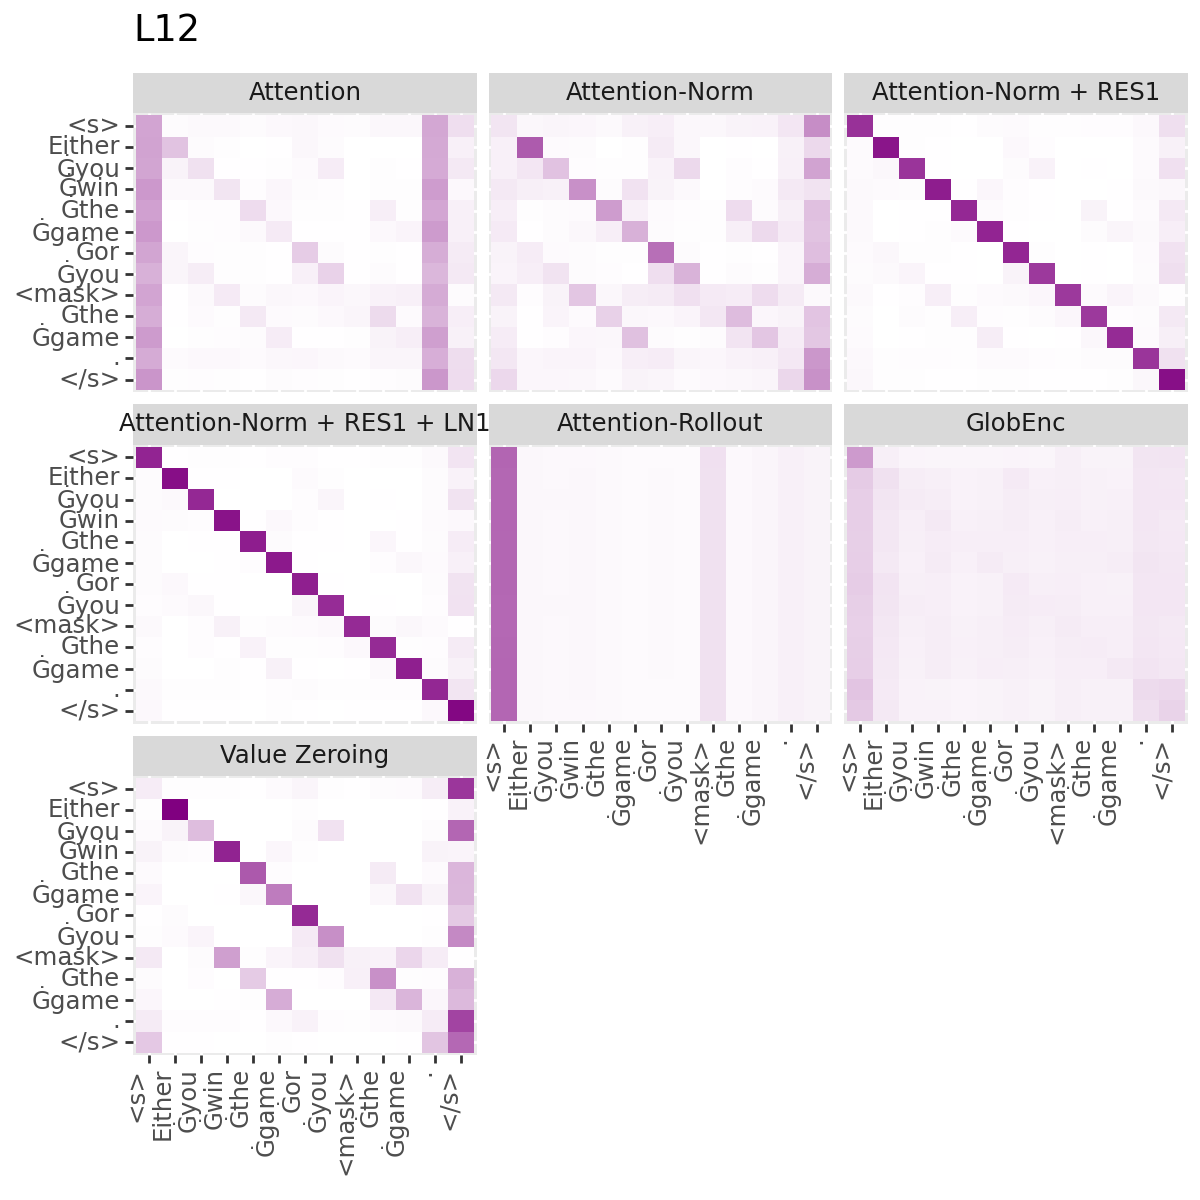

<Figure Size: (600 x 600)>

In [ ]:
# @title Plot scores
tokens = [tokenizer.convert_ids_to_tokens(t) for t in inputs['input_ids'][0].detach().cpu().numpy().tolist()]
token_orders = list(range(len(tokens)))
order_to_token_mapper = {i: tokens[i] for i in token_orders}

NAMES = list(scores.keys())
num_layers, seq_len, _= scores[NAMES[0]].shape
for l in range(num_layers):
    df_list = []
    for name in NAMES:
        df = pd.DataFrame(scores[name][l], index=token_orders, columns=token_orders).reset_index()
        df = df.melt(id_vars='index')
        df.columns = ['x', 'y', 'value']
        df['method'] = name
        df_list.append(df)
    merged_df = pd.concat(df_list)
    merged_df['x'] = pd.Categorical(merged_df['x'], categories=token_orders)
    merged_df['y'] = pd.Categorical(merged_df['y'], categories=token_orders)

    p = (ggplot(merged_df, aes('y', 'x', fill='value'))
        + geom_tile()
        + scale_fill_gradient(low='white', high='purple', guide=False)
        + facet_wrap('~method')
        + theme(axis_text_x=element_text(rotation=90, hjust=1), axis_title_x=element_blank(), axis_title_y=element_blank(), figure_size=(6, 6))
        + scale_x_discrete(labels=[order_to_token_mapper[i] for i in token_orders])
        + scale_y_discrete(labels=[order_to_token_mapper[i] for i in token_orders][::-1], limits=reversed)
        + labs(title=f"L{l+1}")
        )
    display(p)